In [1]:
from tqdm import tqdm
import numpy as np
from scipy import integrate, interpolate

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, vmap

from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from hmf import Transfer

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
jax.config.read('jax_enable_x64')

True

# Basic Parameter Definitions

Some of these are my choice. Some of these are hardcoded by `21cmFAST`.

In [3]:
# M_Sun / Mpc^3
rhoCrit0 = cosmo.critical_density(0).to(u.M_sun / u.Mpc**3).value

# 21cmFAST Definitions for Critical Collapse
SHETH_a = 0.73
SHETH_A = 0.353
SHETH_p = 0.175
Deltac = 1.68

# Default Duty Cycle Parametrization
M_TURN = 5.012e+08
M_MIN = 1e0

# Convenience Methods

In [4]:
# I took these definitions from 21cmFAST. 
def MtoR(M):
    return (3*M/(4*jnp.pi*cosmo.Om0*rhoCrit0)) ** (1/3)

def RtoM(R):
    return 4*jnp.pi*cosmo.Om0*rhoCrit0*R**3 / 3


# This is the fitting function for the Dicke Linear Growth Factor. I took this from 21cmFAST
dicke_z_arr = jnp.linspace(0, 100, 1000)
omegaM_z_arr = cosmo.Om(dicke_z_arr)
def dicke(z):
    omegaM_z = jnp.interp(z, dicke_z_arr, omegaM_z_arr)
    
    dicke_z = 2.5 * omegaM_z / (1.0 / 70.0 + omegaM_z * (209 - omegaM_z) / 140.0 + omegaM_z**(4.0/7.0))
    dicke_0 = 2.5 *  cosmo.Om0 / (1.0 / 70.0 +  cosmo.Om0 * (209 - cosmo.Om0) / 140.0 + cosmo.Om0**(4.0/7.0))
    
    return dicke_z / (dicke_0 * (1.0 + z))


# This is the top-hat window function. I took this from 21cmFAST
def W(k, R):
    kR = k * R
    return jnp.where(kR >= 1e-4, 3.0 * (jnp.sin(kR) / kR**3 - jnp.cos(kR) / kR**2), 0.0)

# This is the derivative of the top-hat window function with respect to R. I took this from 21cmFAST
def dWdR(k, R):
    kR = k * R
    return jnp.where(k >= 1e-10, (9 * jnp.cos(kR) * k / kR**3) + (3 * jnp.sin(kR) * (1 - 3 / (kR * kR)) / (kR * R)), 0.0)

# Generating Interpolated Power Spectrum from EH

In [5]:
tr = Transfer(cosmo_model = cosmo, transfer_model = 'EH', z = 0)

interp_k = tr.k * cosmo.h # to u without `h`
interp_T = tr.transfer_function / np.amax(tr.transfer_function) # normalized
interp_P = interp_k**2 * interp_T**2 * interp_k**cosmo.to_format('mapping')['meta']['n']

# Defining an interpolated Power Spectrum that must be normalized to match Sigma8
PowerSpectrum = interpolate.CubicSpline(interp_k, interp_P)

# Doing the Sigma8 Normalization
Radius_8 = 8.0/cosmo.h 
integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) * W(np.exp(logk), Radius_8)**2
result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
sigma_norm = cosmo.to_format('mapping')['meta']['sigma8']/np.sqrt(result[0])

# Redefining the Power Spectrum to be consistent with Sigma8
#PowerSpectrum = interpolate.CubicSpline(interp_k, sigma_norm**2*interp_P)
interp_k = jnp.asarray(interp_k)
interp_P = jnp.asarray(interp_P)
sigma_norm = jnp.asarray(sigma_norm)
PowerSpectrum = lambda k: jnp.interp(k, interp_k, sigma_norm**2*interp_P)

# Operations on the Power Spectrum

In [6]:
@jit
def sigma_z0(M):
    radius = MtoR(M)
    
    # integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) * W(np.exp(logk), radius)**2
    # result = np.sqrt(integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)[0])
    logk_arr = jnp.linspace(jnp.log(interp_k[0]), jnp.log(interp_k[-1]), 300)
    integrand = jnp.exp(logk_arr)* PowerSpectrum(jnp.exp(logk_arr)) * W(jnp.exp(logk_arr), radius)**2
    result = jnp.sqrt(jnp.trapz(integrand, logk_arr))
    
    return result

@jit
def dsigmasqdm_z0(M):
    radius = MtoR(M)
        
    # Calculating drdrm
    drdm = 1 / (4 * jnp.pi * cosmo.Om0 * rhoCrit0 * radius**2)
    
    # Defining the integrand
    # integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) * \
    #                          2 * W(np.exp(logk), radius) * dWdR(np.exp(logk), radius) * drdm
    # result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)[0]
    logk_arr = jnp.linspace(jnp.log(interp_k[0]), jnp.log(interp_k[-1]), 300)
    integrand = jnp.exp(logk_arr)* PowerSpectrum(jnp.exp(logk_arr)) * \
                             2 * W(jnp.exp(logk_arr), radius) * dWdR(jnp.exp(logk_arr), radius) * drdm
    result = jnp.trapz(integrand, logk_arr)

    return result

############################################################################
###   The above is slow so we will define some interpolating functions   ###
############################################################################


interp_m = jnp.geomspace(M_MIN, RtoM(512), 4001)
interp_sigma = vmap(sigma_z0, in_axes = 0)(interp_m)
interp_dsigma_dm = vmap(dsigmasqdm_z0, in_axes = 0)(interp_m)
    
# sigma_z0 = interpolate.CubicSpline(interp_m, interp_sigma)
# dsigmasqdm_z0 = interpolate.CubicSpline(interp_m, interp_dsigma_dm)
sigma_z0 = lambda M: jnp.interp(M, interp_m, interp_sigma)
dsigmasqdm_z0 = lambda M: jnp.interp(M, interp_m, interp_dsigma_dm)

# Press Schechter and Sheth Tormen Mass Functions

In [7]:
# This is the Sheth-Tormen Mass Function. This is exactly taken from 21cmFAST, which is why the conventions
# are a little bit weird. Anyways, this matches HMF precisely if the Sheth-Tormen parameteres are tuned
# to match those used by 21cmFAST.
@jit
def dNdM_st(M, z):
    
    growthf = dicke(z)

    sigma = sigma_z0(M)
    dsigmadm = dsigmasqdm_z0(M)

    sigma = sigma * growthf
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma))

    nuhat = jnp.sqrt(SHETH_a) * Deltac / sigma

    return (-(cosmo.Om0)*rhoCrit0/M) * (dsigmadm/sigma) * jnp.sqrt(2./jnp.pi)*SHETH_A * (1+nuhat**(-2*SHETH_p)) * nuhat * jnp.exp(-nuhat*nuhat/2.0)

# This is the Press-Schechter Mass Function. This is taken exactly from 21cmFAST, which is why the conventions
# are a little bit weird. This precisely matches the HMF module.
@jit
def dNdM(M, z):
    growthf = dicke(z)

    sigma = sigma_z0(M)
    dsigmadm = dsigmasqdm_z0(M)

    sigma = sigma * growthf
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma))

    return (-(cosmo.Om0)*rhoCrit0/M) * jnp.sqrt(2/jnp.pi) * (Deltac/(sigma*sigma)) * dsigmadm * jnp.exp(-(Deltac*Deltac)/(2*sigma*sigma))


# I had to implement this myself. I'm not actually sure 21cmFAST does this totally correctly, but I think this
# should be close enough. It comes from Eq. 7.81 in Galaxy 
# This is the conditional Press-Schechter
@jit
def dNdM_Conditional(MR, deltaR, z):
    
    delta2 = deltaR / dicke(z)
    delta1 = Deltac / dicke(z)
    
    S1 = sigma_z0(interp_m)**2
    S2 = sigma_z0(MR)**2
    
    dS1_dM1 = dsigmasqdm_z0(interp_m)

    n12 = (delta1 - delta2) / jnp.sqrt(S1 - S2)
    differential = -interp_m * (delta1-delta2) / 2 / n12 / jnp.sqrt(S1-S2)**3*dS1_dM1
    differential *= (S1 > S2)
    
    fPS = jnp.sqrt(2/jnp.pi)*n12*jnp.exp(-n12**2 / 2)
    
    return jnp.where(S1 > S2, 1 / interp_m**2 * fPS * jnp.abs(differential), jnp.nan) * (cosmo.Om0*rhoCrit0)

# Load Annihilation Rates

In [8]:
annihilation_dict = np.load('./Annihilation_Dictionary.npz')

annihilation_z = annihilation_dict['z_range']
annihilation_mass = annihilation_dict['mass_range']
annihilation_rate = annihilation_dict['annihilation_rates']
# [ ] In GeV^2 / cm^3 / Mpc^3
# [X] In Msun(energy)^2 / pc^3 / Mpc^3
print(np.min(annihilation_rate), np.max(annihilation_rate))

6.993233434761833e+43 4.440930025452955e+81


In [9]:
log_interpolator = interpolate.RegularGridInterpolator((annihilation_z, np.log10(annihilation_mass)),
                                                       np.log10(annihilation_rate),
                                                       bounds_error = False, 
                                                       fill_value = np.amin(np.log10(annihilation_rate)))

def annihilation_interpolator(z, M):
    return 10**log_interpolator([z, np.log10(M)])

In [10]:
interpolated_annihilation_rates = np.zeros((len(annihilation_z), len(interp_m)))

for i,z in enumerate(tqdm(annihilation_z)):
    interpolated_annihilation_rates[i] = np.array([annihilation_interpolator(z, M) for M in interp_m])[:, 0]

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:24<00:00,  2.08it/s]


# Generate HMF Tables for the Conditional Press-Schechter

In [11]:
z_range = annihilation_z
delta_range = np.linspace(-1, 1.5, 128)
r_range = np.geomspace(.1, 512, 128)

cond_dndm = np.zeros((len(z_range), len(delta_range), len(r_range), len(interp_m)))

func = jit(vmap(lambda r: jnp.nan_to_num(dNdM_Conditional(RtoM(r), delta, z)), in_axes = 0))

for i, z in enumerate(tqdm(z_range)):
    for j, delta in enumerate(delta_range):
        cond_dndm[i, j, :] = func(r_range)

100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


In [12]:
cond_annihilation_table =np.zeros((len(z_range), len(delta_range), len(r_range)))

for i in tqdm(range(cond_annihilation_table.shape[0])):
    for j in range(cond_annihilation_table.shape[1]):
        for k in range(cond_annihilation_table.shape[2]):
            cond_annihilation_table[i,j,k] = np.trapz(interpolated_annihilation_rates[i] * cond_dndm[i,j,k], interp_m)

100%|██████████| 51/51 [00:22<00:00,  2.28it/s]


# Generate HMF for Unconditional Press-Schechter

In [13]:
print(np.min(cond_annihilation_table), np.max(cond_annihilation_table))
print(np.min(interpolated_annihilation_rates), np.max(interpolated_annihilation_rates))

9.853462526006978e+57 5.561674185620681e+67
6.993233434761861e+43 4.396505099455398e+81


In [17]:
ps_annihilation_table = np.zeros((len(z_range)))

for i in range(ps_annihilation_table.shape[0]):
    ps_annihilation_table[i] = np.trapz(interpolated_annihilation_rates[i] * dNdM(interp_m, z_range[i]), interp_m)

(1e+40, 7.634259126928641e+73)

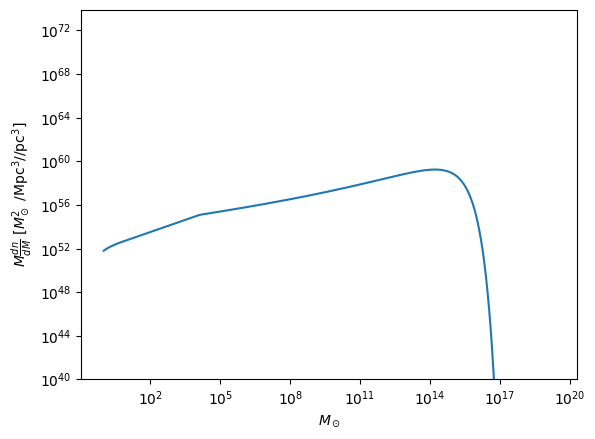

In [19]:
plt.plot(interp_m,interp_m*dNdM(interp_m, 0)*interpolated_annihilation_rates[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_\odot$')
plt.ylabel(r'$M \frac{dn}{dM}$ [$M_\odot^2$ /Mpc$^3/$/pc$^{3}$]')
plt.ylim(1e40, None)

# Generate HMF for Sheth-Tormen

In [20]:
st_annihilation_table = np.zeros((len(z_range)))

for i in range(ps_annihilation_table.shape[0]):
    st_annihilation_table[i] = np.trapz(interpolated_annihilation_rates[i] * dNdM_st(interp_m, z_range[i]), interp_m)

# Save the Results

In [21]:
res_dict = dict()
res_dict['z_range'] = z_range
res_dict['delta_range'] = delta_range
res_dict['r_range'] = r_range

res_dict['Conditional_Annihiation'] = cond_annihilation_table
res_dict['Unconditional_Annihilation'] = ps_annihilation_table
res_dict['ShethTormen_Annihilation'] = st_annihilation_table

np.savez('./PWave_Dictionary.npz', **res_dict)

In [22]:
cond_annihilation_table.shape, ps_annihilation_table.shape, st_annihilation_table.shape

((51, 128, 128), (51,), (51,))

In [27]:
cmp = np.load('../../data/pwave/PWave_Dictionary.npz')

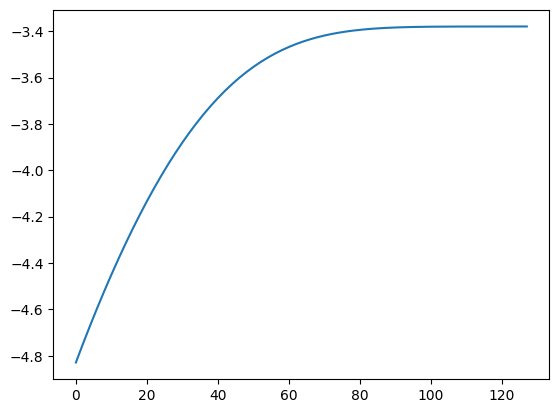

In [30]:
plt.plot(np.log(cmp['Conditional_Annihiation'][25][64]))

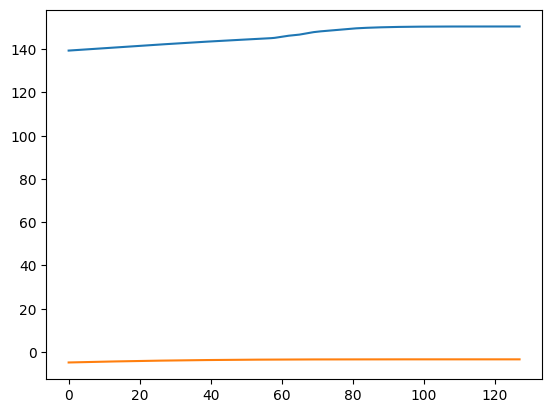

In [29]:
plt.plot(np.log(cond_annihilation_table[25][64]))
plt.plot(np.log(cmp['Conditional_Annihiation'][25][64]))